In [1]:
import numpy as np
import astropy.units as u
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
from importlib import reload
import time 

from matplotlib.patches import Circle, Rectangle

import scoobpsf
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3
import scoobpsf.scoobi as scoobi

import lina

dm_channel = dm_channel
DM = scoob_utils.connect_to_dmshmim(channel=dm_channel) # channel used for writing to DM
DMT = scoob_utils.connect_to_dmshmim(channel='dm00disp') # the total shared memory image


Could not import scoobpy. Testbed interface unavailable.


In [1]:
import scoobpy
from scoobpy import utils as scoob_utils
from magpyx.utils import ImageStream

import purepyindi
from purepyindi import INDIClient
client0 = INDIClient('localhost', 7624)
client0.start()

import purepyindi2
from purepyindi2 import IndiClient
client = IndiClient()
client.connect()
client.get_properties()

ModuleNotFoundError: No module named 'magpyx'

In [2]:
reload(scoobi)
tbi = scoobi.SCOOBI(cam_channel='nsvcam', dm_channel='dm00disp05')
# tbi.zero_dm()

Succesfully initialized testbed interface.


In [3]:
scoobi.move_psf(60, 0)

In [13]:
tbi.bias = 63

In [4]:
tbi.exp_time = 0.1*u.millisecond
tbi.Nframes = 100

In [10]:
tbi.attenuation = 26

In [11]:
tbi.normalize = True
# tbi.normalize = False

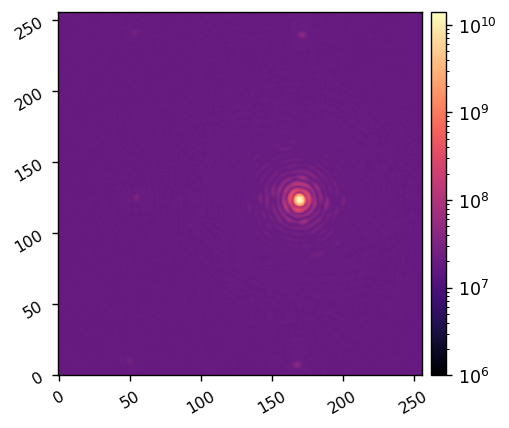

In [12]:
raw_im = tbi.snap()
imshow1(raw_im, lognorm=True, vmin=1e6)

In [13]:
tbi.Imax_ref = xp.max(raw_im)

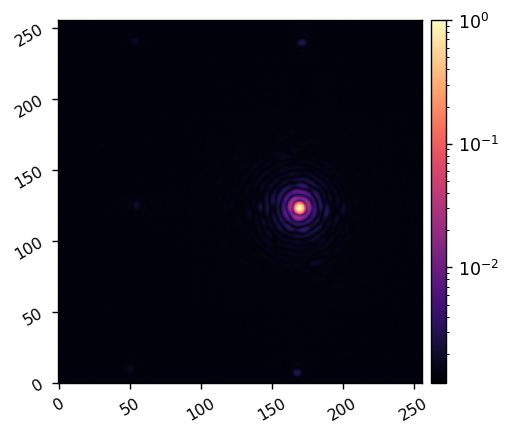

In [14]:
ref_psf = tbi.snap()
imshow1(ref_psf, lognorm=True)

In [15]:
scoobi.move_psf(-60,0)

In [31]:
scoobi.move_psf(-1,0)

In [27]:
scoobi.move_psf(0,-1)

In [16]:
tbi.exp_time = 2.5*u.millisecond

In [32]:
tbi.attenuation = 11

In [19]:
tbi.Nframes = 10

In [44]:
tbi.npsf = 128
tbi.x_shift = 3
tbi.y_shift = 5

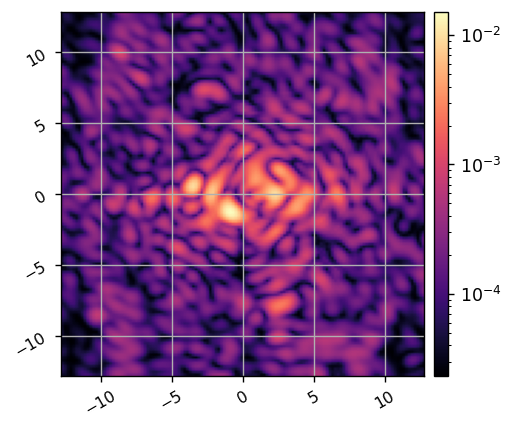

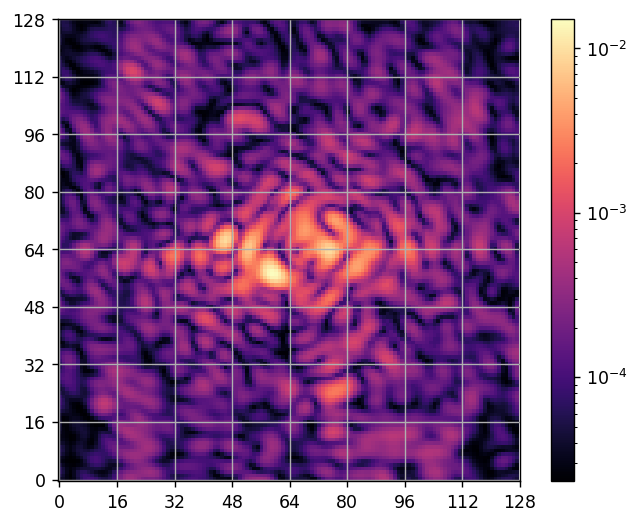

In [46]:
ref_im = tbi.snap(plot=True)

nticks = 8
ticks = np.arange(0, tbi.npsf+1, tbi.npsf//nticks)
plt.figure(dpi=125)
plt.imshow(ensure_np_array(ref_im), norm=LogNorm(), cmap='magma')
plt.colorbar()
plt.xticks(ticks)
plt.yticks(ticks)
plt.grid()



In [49]:
pixelscale_lamD = 32/(128-10)
print(pixelscale_lamD)

0.2711864406779661


In [50]:
tbi.psf_pixelscale_lamD = pixelscale_lamD

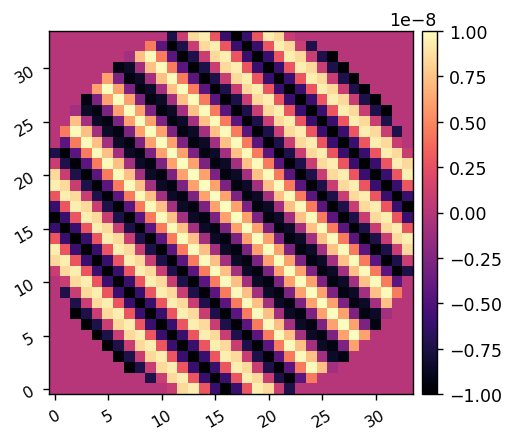

In [40]:
Nact = 34
xpp = np.arange(-Nact//2, Nact//2) + 1/2
ppx, ppy = np.meshgrid(xpp,xpp)
amp = 1e-8
separation = 5
comm1 = amp*np.cos(2*np.pi*(ppx + ppy)*separation/Nact)*tbi.dm_mask
# comm2 = amp*np.cos(2*np.pi*(ppx - ppy)*separation/Nact)*model.dm_mask

imshow1(comm1)
# model.set_dm1(ensure_np_array(comm1))

In [110]:
xp.array

<function cupy._creation.from_data.array(obj, dtype=None, copy=True, order='K', subok=False, ndmin=0)>

In [38]:
from astropy.io import fits
response_matrix = xp.array(fits.getdata('jacobian.fits'))

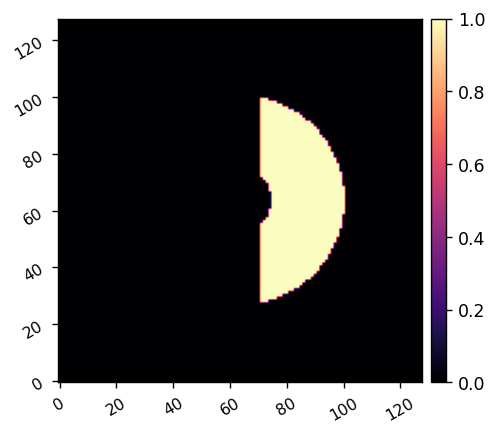

In [51]:
control_mask = lina.utils.create_annular_focal_plane_mask(tbi, 3, 10, 2, plot=True)

In [58]:
tbi.Nframes = 20

In [112]:
tbi.dm_delay = 0.1

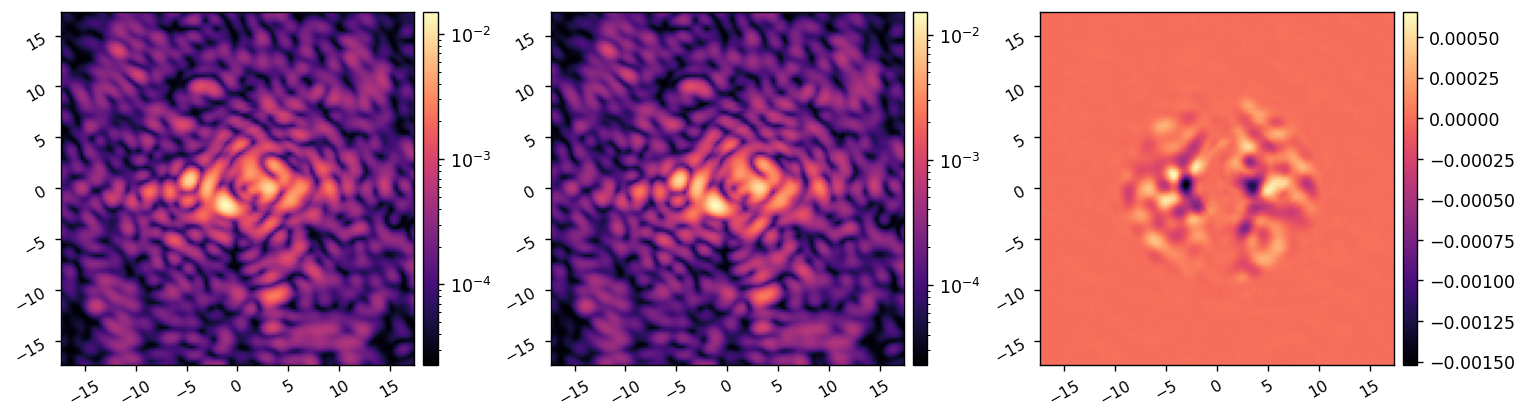

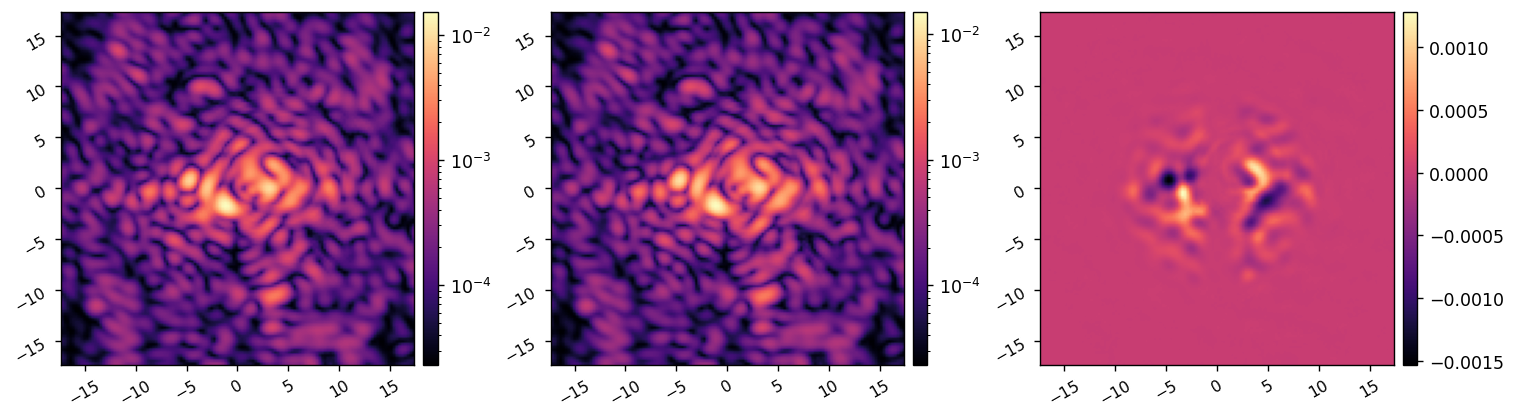

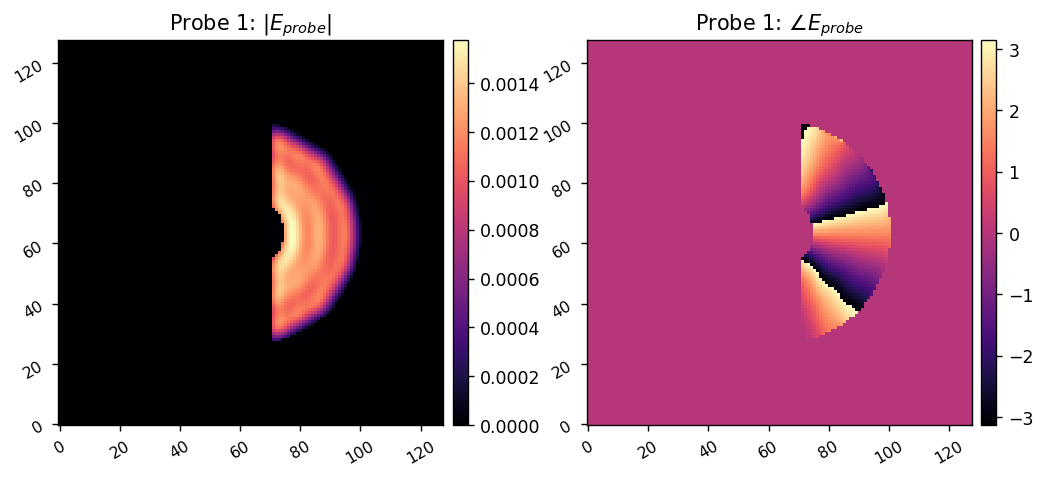

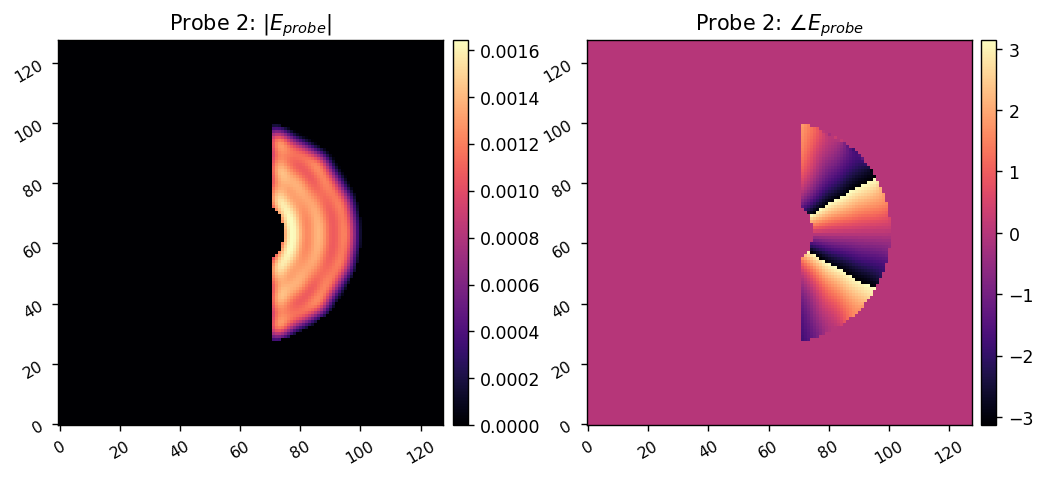

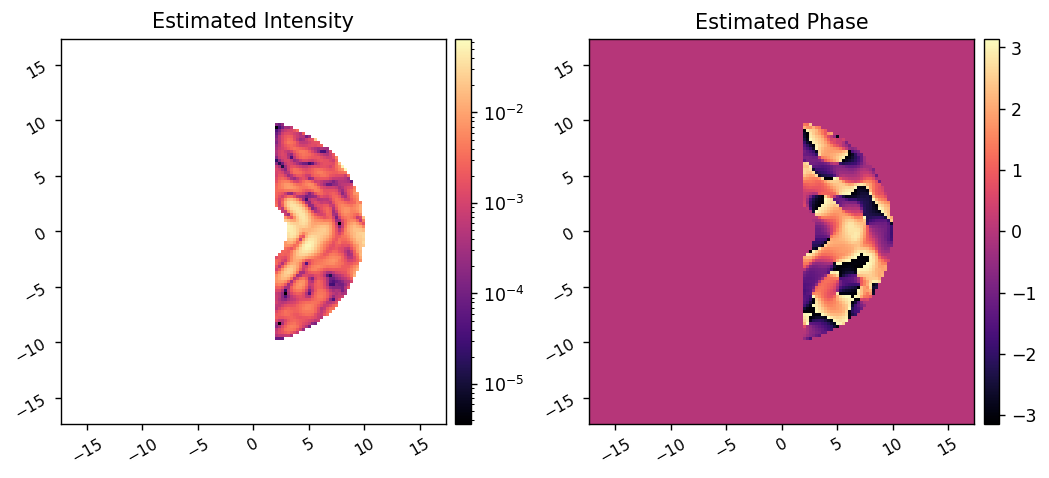

In [59]:
probe_amp = 5e-9
probe_modes = lina.utils.create_fourier_probes(tbi, control_mask, fourier_sampling=0.25, nprobes=2)
probes = probe_amp*probe_modes

est0 = lina.pwp.run_pwp_bp(tbi, control_mask, probes, use='J', jacobian=response_matrix, plot=True)

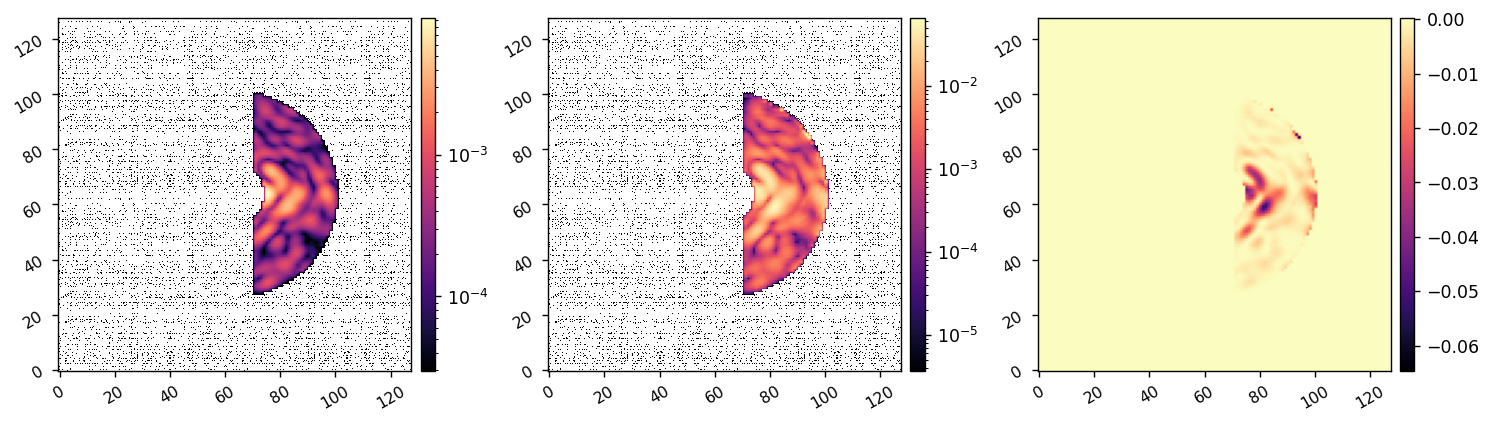

In [73]:
Iest = xp.abs(est0)**2
imshow3(ref_im*control_mask, Iest, ref_im*control_mask-Iest, lognorm1=True, lognorm2=True)

# Run EFC + PWP

In [57]:
poke_modes = lina.utils.create_all_poke_modes(tbi.dm_mask)

In [69]:
tbi.reset_dm()

images = xp.array([ref_im])
estimates = xp.array([est0])
dm_commands = xp.array([tbi.get_dm()])

In [67]:
type(tbi.get_dm())

numpy.ndarray

Beginning closed-loop EFC.
	Running iteration 1/3.
Using run_pwp_bp to estimate electric field


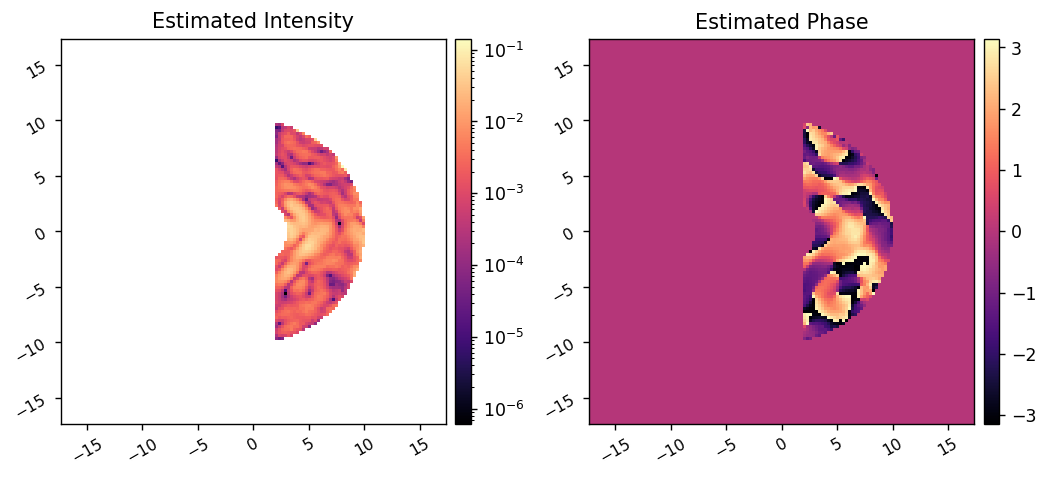

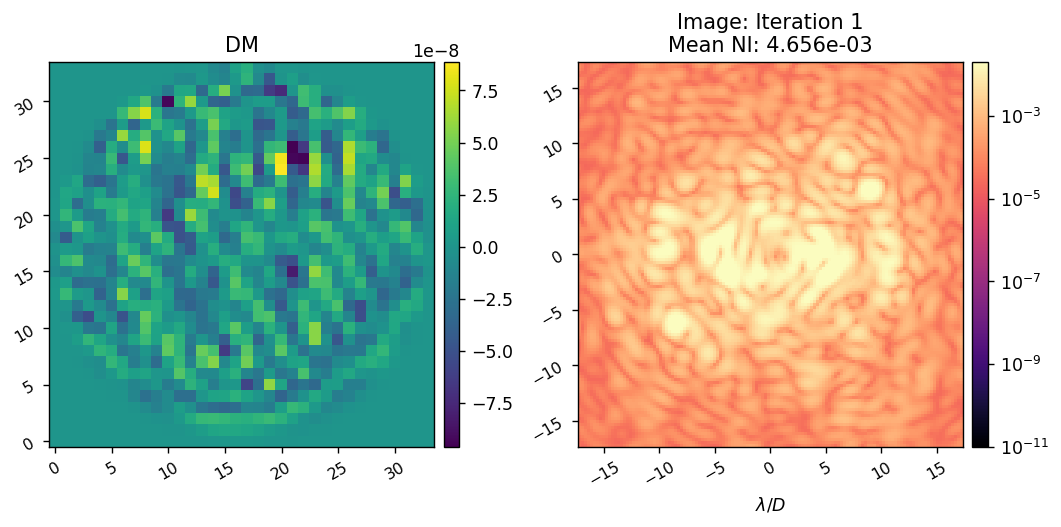

	Running iteration 2/3.
Using run_pwp_bp to estimate electric field


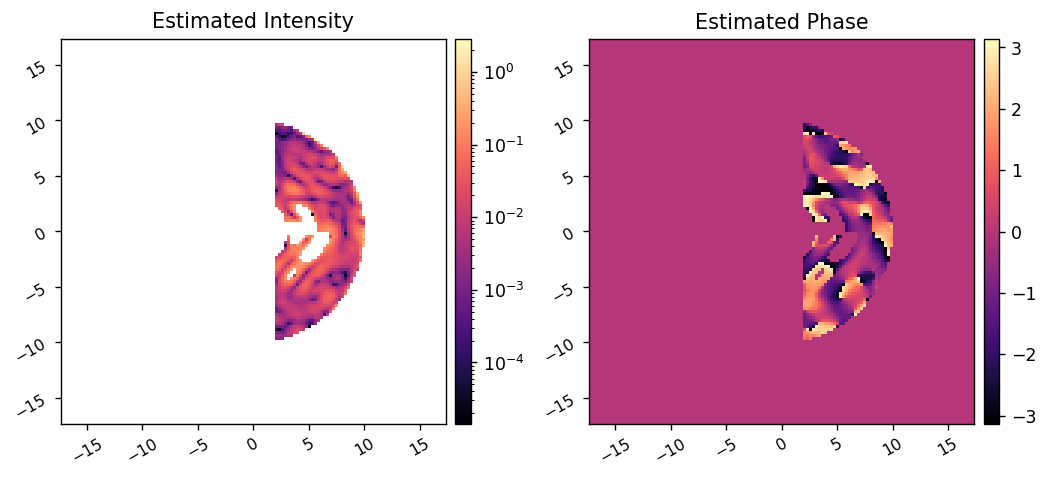

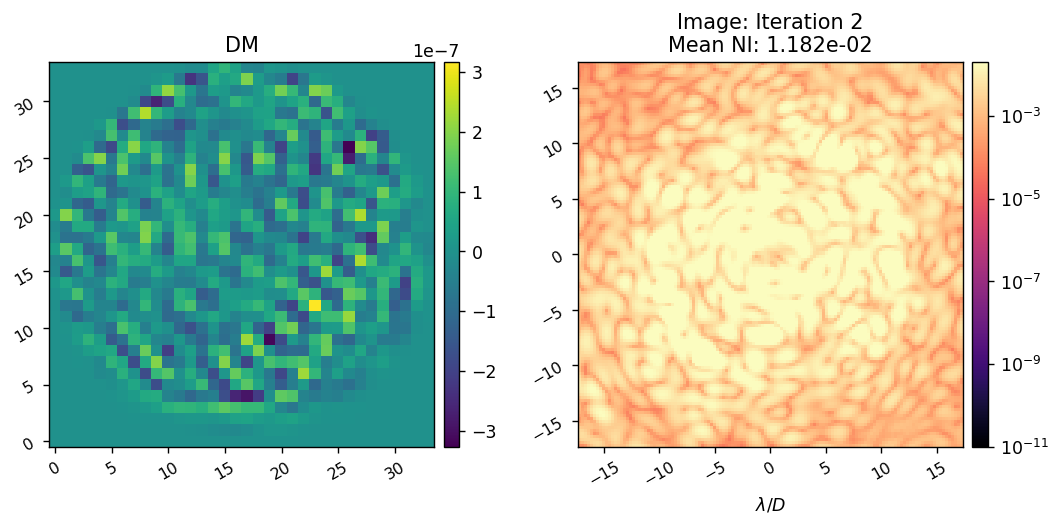

	Running iteration 3/3.
Using run_pwp_bp to estimate electric field


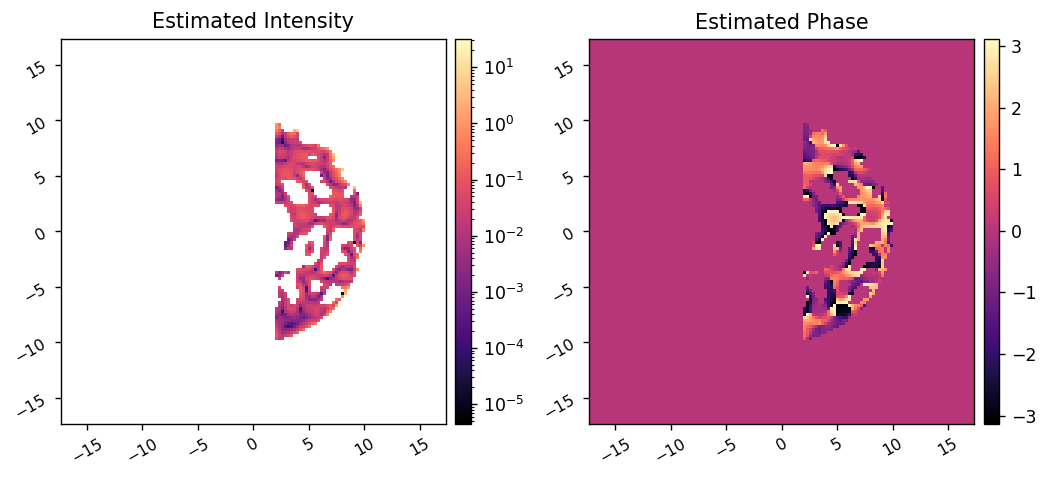

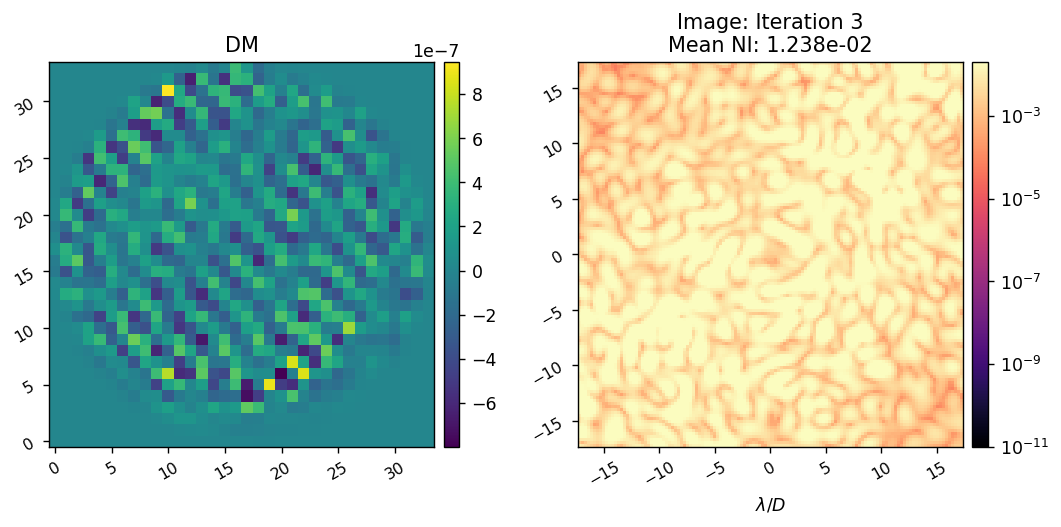

EFC completed in 11.951 sec.


In [68]:
reload(lina.efc)

pwp_fun = lina.pwp.run_pwp_bp
probe_amp = 2e-9
pwp_params = {
    'probes':probe_amp*probe_modes,
    'control_mask':control_mask,
    'use':'J',
    'jacobian':response_matrix,
    'plot_est':True,
}

condition = -2
# condition = -4
control_matrix = lina.utils.beta_reg(response_matrix, condition)

images, estimates, dm_commands = lina.efc.run(tbi, 
                                              poke_modes,
                                              control_matrix,
                                              control_mask, 
                                              est_fun=pwp_fun,
                                              est_params=pwp_params,
                                              loop_gain=0.5, 
                                              leakage=0.0,
                                              iterations=3,
                                              plot_all=True,
                                              plot_current=True,
                                              plot_sms=False,
                                              plot_radial_contrast=False,
                                              old_images=images,
                                              old_fields=estimates,
                                              old_commands=dm_commands,
                                             )